In [1]:
from models import  vae_EUCL, vae_HYP, ResNetvae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 51200))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=64, 
                                         num_workers=1, pin_memory=True, shuffle=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

In [4]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [5]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            print(x.shape)
            loss = ((x - x_hat)**2).sum() 
            #+ vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [6]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      img = img.to(device)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\julia/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:22<00:00, 10.5MB/s]


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

C:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


	 partial train loss (single batch): 407651.687500
	 partial train loss (single batch): 328223.437500
	 partial train loss (single batch): 283220.031250
	 partial train loss (single batch): 195412.109375
	 partial train loss (single batch): 118718.343750
	 partial train loss (single batch): 99892.000000
	 partial train loss (single batch): 89643.437500
	 partial train loss (single batch): 85734.437500
	 partial train loss (single batch): 81734.015625
	 partial train loss (single batch): 80251.289062
	 partial train loss (single batch): 80123.960938
	 partial train loss (single batch): 75682.125000
	 partial train loss (single batch): 70336.039062
	 partial train loss (single batch): 74965.281250
	 partial train loss (single batch): 75825.828125
	 partial train loss (single batch): 64644.707031
	 partial train loss (single batch): 72469.656250
	 partial train loss (single batch): 63291.125000
	 partial train loss (single batch): 61398.289062
	 partial train loss (single batch): 65144.06

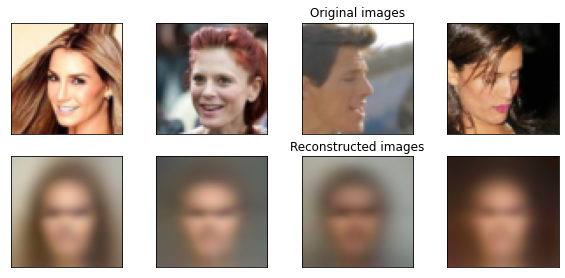

	 partial train loss (single batch): 37700.703125
	 partial train loss (single batch): 35396.453125
	 partial train loss (single batch): 36979.449219
	 partial train loss (single batch): 39725.242188
	 partial train loss (single batch): 39870.722656
	 partial train loss (single batch): 39614.890625
	 partial train loss (single batch): 35090.082031
	 partial train loss (single batch): 36572.917969
	 partial train loss (single batch): 36000.023438
	 partial train loss (single batch): 38068.964844
	 partial train loss (single batch): 37027.292969
	 partial train loss (single batch): 35258.687500
	 partial train loss (single batch): 37820.375000
	 partial train loss (single batch): 38096.410156
	 partial train loss (single batch): 38800.046875
	 partial train loss (single batch): 38855.148438
	 partial train loss (single batch): 38869.847656
	 partial train loss (single batch): 36725.093750
	 partial train loss (single batch): 34942.976562
	 partial train loss (single batch): 38969.152344


KeyboardInterrupt: 

In [7]:
model = ResNetvae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=100, device=device)
model.to(device)
print(model)
epochs = 5
learning_rate = 5e-4

#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model, trainloader, optimizer)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)


# save model checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, 'outputs/resnet_model.pth')

#Resuming Model Training

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 3 number of epochs...
Train for 3 more epochs...
	 partial train loss (single batch): 11724.625000
	 partial train loss (single batch): 11957.101562
	 partial train loss (single batch): 12227.484375
	 partial train loss (single batch): 12439.525391
	 partial train loss (single batch): 12620.724609
	 partial train loss (single batch): 11574.592773
	 partial train loss (single batch): 11857.127930
	 partial train loss (single batch): 12021.842773
	 partial train loss (single batch): 11363.573242
	 partial train loss (single batch): 11830.859375
	 partial train loss (single batch): 12242.429688
	 partial train loss (single batch): 12345.312500
	 partial train loss (single batch): 12979.529297
	 partial train loss (single batch): 12066.226562
	 partial train loss (single batch): 11503.083984
	 partial train loss (single batch):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/3 	 train loss 181.967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


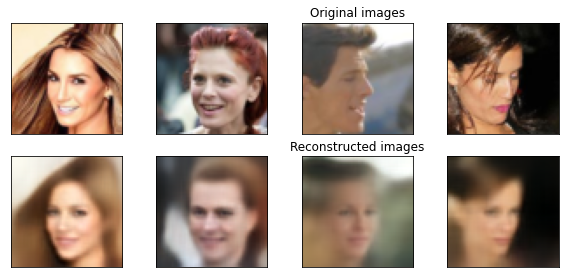

	 partial train loss (single batch): 11870.232422
	 partial train loss (single batch): 11346.730469
	 partial train loss (single batch): 11618.518555
	 partial train loss (single batch): 11560.382812
	 partial train loss (single batch): 12272.460938
	 partial train loss (single batch): 11948.964844
	 partial train loss (single batch): 12288.097656
	 partial train loss (single batch): 11067.062500
	 partial train loss (single batch): 11766.259766
	 partial train loss (single batch): 12088.509766
	 partial train loss (single batch): 12093.239258
	 partial train loss (single batch): 11564.250000
	 partial train loss (single batch): 11084.185547
	 partial train loss (single batch): 11738.723633
	 partial train loss (single batch): 11721.571289
	 partial train loss (single batch): 11978.279297
	 partial train loss (single batch): 11839.181641
	 partial train loss (single batch): 10765.844727
	 partial train loss (single batch): 12322.392578
	 partial train loss (single batch): 12070.005859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


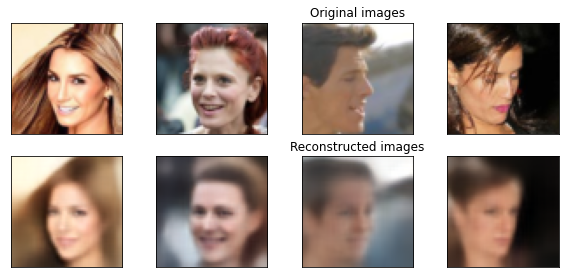

	 partial train loss (single batch): 11822.010742
	 partial train loss (single batch): 11313.035156
	 partial train loss (single batch): 11582.600586
	 partial train loss (single batch): 11791.003906
	 partial train loss (single batch): 11821.269531
	 partial train loss (single batch): 11195.167969
	 partial train loss (single batch): 11348.490234
	 partial train loss (single batch): 10308.688477
	 partial train loss (single batch): 12338.649414
	 partial train loss (single batch): 11408.234375
	 partial train loss (single batch): 11255.955078
	 partial train loss (single batch): 12153.547852
	 partial train loss (single batch): 11335.225586
	 partial train loss (single batch): 11190.716797
	 partial train loss (single batch): 12431.098633
	 partial train loss (single batch): 11108.340820
	 partial train loss (single batch): 11328.206055
	 partial train loss (single batch): 12261.068359
	 partial train loss (single batch): 11210.314453
	 partial train loss (single batch): 10742.143555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


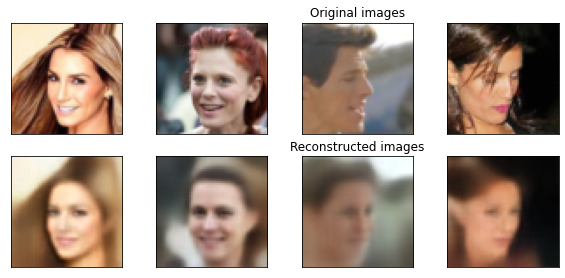

In [ ]:
# # load the trained model
# model_resume = model.to(device) # initilize the model
# # initialize optimizer  before loading optimizer state_dict
# epochs_new = 5
# learning_rate_new = 5e-4
# optimizer_new = optim.Adam(model_resume.parameters(), lr=learning_rate_new)


# checkpoint = torch.load('outputs/model.pth')

# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')

# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')

# epochs = checkpoint['epoch']
# # load the criterion
# loss_function = checkpoint['loss']
# print('Trained model loss function loaded...')
# print(f"Previously trained for {epochs} number of epochs...")

# # train for more epochs
# epochs = epochs_new
# print(f"Train for {epochs} more epochs...")


# #New Training loop
# for epoch in range(epochs):
#    train_loss = train_epoch(model_resume, trainloader, optimizer_new)
#    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
#    plot_ae_outputs(model.encoder, model.decoder,n=4)

# # save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/model.pth')

#5,3,3,3,5

In [ ]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()